In [1]:
import torch
from msc_project.circuits_custom.custom_stepmlp import NPCompatibleStepMLP 
from circuits.examples.keccak import Keccak
from circuits.utils.format import format_msg
from msc_project.utils.model_utils import get_mlp_layers, process_mlp_layers, unfold_stepmlp_parameters
from msc_project.evaluation.metrics import kl_divergence, earth_movers_distance, ks_test
import matplotlib.pyplot as plt
import os
from scipy import stats
from transformers import AutoModelForCausalLM
from pathlib import Path
import pandas as pd

/homes/55/bella/miniconda3/envs/msc-project-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base = "/scratch/local/ssd/bella/msc-project/results/genetic_algorithm_experiments"
model_file = "ga_optimised_stepml_model.pth"

In [3]:
def unfold_parameters(param_dict):

    weights = []
    biases = []
    for name, params in param_dict.items():
        if "weight" in name:
            folded = params.detach().data
            bias = folded[:, 0].view(-1)
            weight = folded[:, 1:].reshape(-1)
            weights.append(weight)
            biases.append(bias)

    weights_tensor = torch.cat(weights) if weights else torch.tensor([])
    biases_tensor = torch.cat(biases) if biases else torch.tensor([])

    return weights_tensor, biases_tensor

In [5]:
target_model = AutoModelForCausalLM.from_pretrained("gpt2")
mlp_layers = get_mlp_layers(target_model)
target_weights, target_bias = process_mlp_layers(mlp_layers, 1.0)
target_weights_mean, target_weights_std, target_weights_kurt = target_weights.mean(), target_weights.std(), stats.kurtosis(target_weights)
target_bias_mean, target_bias_std, target_bias_kurt = target_bias.mean(), target_bias.std(), stats.kurtosis(target_bias)

In [7]:
keccak = Keccak(c=20, log_w=1, n=3)
trigger_bits = format_msg("Test", keccak.msg_len)
payload_bits = format_msg("tseT", keccak.d)

mlp = NPCompatibleStepMLP.create_with_backdoor(
    trigger=trigger_bits.bitlist, payload=payload_bits.bitlist, k=keccak
)

In [8]:
init_weights, init_bias = unfold_stepmlp_parameters(mlp)

In [9]:
def evaluate_model(model):
    w, b = unfold_stepmlp_parameters(model)

    w_mean = w.mean()
    b_mean = b.mean()
    w_std = w.std()
    b_std = b.std()
    w_kurt = stats.kurtosis(w)
    b_kurt = stats.kurtosis(b)
    w_kl_div = kl_divergence(w, target_weights)
    b_kl_div = kl_divergence(b, target_bias)
    w_emd = earth_movers_distance(w, target_weights)
    b_emd = earth_movers_distance(b, target_bias)
    w_ks_stat = ks_test(w, target_weights)[0]
    b_ks_stat = ks_test(b, target_bias)[0]

    return w_mean, b_mean, w_std, b_std, w_kurt, b_kurt, w_kl_div, b_kl_div, w_emd, b_emd, w_ks_stat, b_ks_stat


In [10]:
def evaluate_solution(solution_path):

    fitness_func = Path(solution_path).parent.parent.name
    run_id = Path(solution_path).parent.name
    
    m = torch.load(solution_path)
    w, b = unfold_parameters(m)

    success = not(torch.equal(init_weights, w)) and not(torch.equal(init_bias, b))
    w_mean = w.mean()
    b_mean = b.mean()
    w_std = w.std()
    b_std = b.std()
    w_kurt = stats.kurtosis(w)
    b_kurt = stats.kurtosis(b)
    w_kl_div = kl_divergence(w, target_weights)
    b_kl_div = kl_divergence(b, target_bias)
    w_emd = earth_movers_distance(w, target_weights)
    b_emd = earth_movers_distance(b, target_bias)
    w_ks_stat = ks_test(w, target_weights)[0]
    b_ks_stat = ks_test(b, target_bias)[0]

    result = f"{run_id},{fitness_func},{success},{w_kl_div},{b_kl_div},{w_emd},{b_emd},{w_ks_stat},{b_ks_stat},{w_mean},{b_mean},{w_std},{b_std},{w_kurt},{b_kurt}\n"
    return result, w, b    

# Simple Fitness Function

In [11]:
experiment_dir = f"{base}/simple_fitness_func"

In [12]:
simple_fitness_func_weights = []
simple_fitness_func_bias = []

for filename in os.listdir(experiment_dir):
    file_path = os.path.join(experiment_dir, filename)

    if os.path.isdir(file_path):
        model_path = os.path.join(file_path, model_file)
        m = torch.load(model_path)
        w, b = unfold_parameters(m)
        
        simple_fitness_func_weights.append(w)
        simple_fitness_func_bias.append(b)

# Distribution-Aware Fitness Function

In [14]:
experiment_dir = f"{base}/distribution_aware_fitness_func"

In [15]:
daff_weights = []
daff_bias = []

for filename in os.listdir(experiment_dir):
    file_path = os.path.join(experiment_dir, filename)

    if os.path.isdir(file_path):
        model_path = os.path.join(file_path, model_file)
        m = torch.load(model_path)
        w, b = unfold_parameters(m)
        
        daff_weights.append(w)
        daff_bias.append(b)

# Magnitude-Aware Fitness Function

In [16]:
experiment_dir = f"{base}/magnitude_aware_fitness_func"

In [17]:
maff_weights = []
maff_bias = []

for filename in os.listdir(experiment_dir):
    file_path = os.path.join(experiment_dir, filename)

    if os.path.isdir(file_path):
        model_path = os.path.join(file_path, model_file)
        m = torch.load(model_path)
        w, b = unfold_parameters(m)
        
        maff_weights.append(w)
        maff_bias.append(b)

# Simple Fitness Function With Bias Boost

In [18]:
experiment_dir = f"{base}/simple_fitness_with_bias_boost"

In [19]:
sffbb_weights = []
sffbb_bias = []

for filename in os.listdir(experiment_dir):
    file_path = os.path.join(experiment_dir, filename)

    if os.path.isdir(file_path):
        model_path = os.path.join(file_path, model_file)
        m = torch.load(model_path)
        w, b = unfold_parameters(m)
        
        sffbb_weights.append(w)
        sffbb_bias.append(b)

# Initial Model Metrics

In [21]:
init_w_mean, init_b_mean, init_w_std, init_b_std, init_w_kurt, init_b_kurt, init_w_kl_div, init_b_kl_div, init_w_emd, init_b_emd, init_w_ks_stat, init_b_ks_stat = evaluate_model(mlp)

# Evaluation

In [32]:
result_file_path = f"{base}/results.csv"

In [33]:
result_df = pd.read_csv(result_file_path)
result_df.columns = result_df.columns.str.replace(' ', '')

In [34]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RunID              40 non-null     object 
 1   FitnessFunction    40 non-null     object 
 2   Success            40 non-null     bool   
 3   KLWeight           40 non-null     float64
 4   KLBias             40 non-null     float64
 5   EMDWeight          40 non-null     float64
 6   EMDBias            40 non-null     float64
 7   KSStatisticWeight  40 non-null     float64
 8   KSStatisticBias    40 non-null     float64
 9   MeanWeight         40 non-null     float64
 10  MeanBias           40 non-null     float64
 11  StdWeight          40 non-null     float64
 12  StdBias            40 non-null     float64
 13  KurtosisWeight     40 non-null     float64
 14  KurtosisBias       40 non-null     float64
dtypes: bool(1), float64(12), object(2)
memory usage: 4.5+ KB


In [35]:
grouped_df = result_df.groupby(["FitnessFunction"])

In [36]:
success_rate = grouped_df.Success.sum() / grouped_df.size()

In [37]:
success_rate

FitnessFunction
distribution_aware_fitness_func    0.6
magnitude_aware_fitness_func       0.0
simple_fitness_func                0.6
simple_fitness_with_bias_boost     0.6
dtype: float64

In [38]:
means = result_df[result_df["Success"] == True].groupby("FitnessFunction", sort=False).mean(numeric_only=True)

In [40]:
means = means.round(4).drop(columns=["Success", "KLWeight", "KLBias"])

In [41]:
print(means.T.to_latex())

\begin{tabular}{lrrr}
\toprule
FitnessFunction & simple_fitness_func & distribution_aware_fitness_func & simple_fitness_with_bias_boost \\
\midrule
EMDWeight & 0.838800 & 0.751500 & 0.877400 \\
EMDBias & 3.864900 & 3.841200 & 3.872000 \\
KSStatisticWeight & 0.397800 & 0.389000 & 0.404100 \\
KSStatisticBias & 0.857000 & 0.869300 & 0.846700 \\
MeanWeight & 0.054500 & 0.055100 & 0.054500 \\
MeanBias & -3.814500 & -3.812100 & -3.800100 \\
StdWeight & 1.202100 & 1.091900 & 1.242400 \\
StdBias & 3.553800 & 3.526600 & 3.577200 \\
KurtosisWeight & 0.480200 & 0.483300 & 0.375700 \\
KurtosisBias & -0.654000 & -0.653700 & -0.640400 \\
\bottomrule
\end{tabular}



In [42]:
stds = result_df[result_df["Success"] == True].groupby("FitnessFunction", sort=False).std(numeric_only=True)

In [43]:
stds = stds.round(4).drop(columns=["Success", "KLWeight", "KLBias"])

In [44]:
clean_table = pd.DataFrame()

In [45]:
for metric in means.columns:
    clean_table[metric] = means[metric].apply(lambda x: f"{x:.3f}") + " ± " + stds[metric].apply(lambda x: f"{x:.3f}")

In [46]:
baseline_row = pd.DataFrame(data=[[init_w_emd, init_b_emd, init_w_ks_stat, init_b_ks_stat, init_w_mean.item(), init_b_mean.item(), init_w_std.item(), init_b_std.item(), init_w_kurt.item(), init_b_kurt.item()]], index=["Baseline"], columns=means.columns).round(3)

In [48]:
target_row = pd.DataFrame(data=[[None, None, None, None, target_weights_mean.item(), target_bias_mean.item(), target_weights_std.item(), target_bias_std.item(), target_weights_kurt, target_bias_kurt]], index=["GPT-2"], columns=means.columns).round(3)

In [49]:
clean_table = pd.concat([clean_table, baseline_row, target_row])

In [50]:
clean_table.index = clean_table.index.str.replace('_fitness_func', '').str.replace('_', ' ').str.title()

In [51]:
clean_table_1 = clean_table[["EMDWeight", "EMDBias", "KSStatisticWeight", "KSStatisticBias"]].drop(index="Gpt-2")
clean_table_2 = clean_table[["MeanWeight","MeanBias","StdWeight","StdBias","KurtosisWeight","KurtosisBias"]]

In [52]:
print(clean_table_1.T.to_latex())

\begin{tabular}{lllll}
\toprule
 & Simple & Distribution Aware & Simple Fitness With Bias Boost & Baseline \\
\midrule
EMDWeight & 0.839 ± 0.034 & 0.751 ± 0.106 & 0.877 ± 0.050 & 0.123000 \\
EMDBias & 3.865 ± 0.005 & 3.841 ± 0.030 & 3.872 ± 0.016 & 3.755000 \\
KSStatisticWeight & 0.398 ± 0.010 & 0.389 ± 0.005 & 0.404 ± 0.008 & 0.500000 \\
KSStatisticBias & 0.857 ± 0.012 & 0.869 ± 0.010 & 0.847 ± 0.015 & 0.969000 \\
\bottomrule
\end{tabular}



In [53]:
print(clean_table_2.T.to_latex())

\begin{tabular}{llllll}
\toprule
 & Simple & Distribution Aware & Simple Fitness With Bias Boost & Baseline & Gpt-2 \\
\midrule
MeanWeight & 0.054 ± 0.003 & 0.055 ± 0.002 & 0.054 ± 0.003 & 0.053000 & -0.001000 \\
MeanBias & -3.814 ± 0.025 & -3.812 ± 0.020 & -3.800 ± 0.032 & -3.804000 & -0.067000 \\
StdWeight & 1.202 ± 0.029 & 1.092 ± 0.152 & 1.242 ± 0.053 & 0.241000 & 0.128000 \\
StdBias & 3.554 ± 0.030 & 3.527 ± 0.048 & 3.577 ± 0.050 & 3.371000 & 0.110000 \\
KurtosisWeight & 0.480 ± 0.253 & 0.483 ± 0.214 & 0.376 ± 0.178 & 12.010000 & 37.568000 \\
KurtosisBias & -0.654 ± 0.038 & -0.654 ± 0.085 & -0.640 ± 0.043 & -0.814000 & 15.353000 \\
\bottomrule
\end{tabular}



In [62]:
grouped_df.get_group("distribution_aware_fitness_func")[grouped_df.get_group("distribution_aware_fitness_func")["Success"] == True]

/tmp/ipykernel_166554/2899830460.py:1: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  grouped_df.get_group("distribution_aware_fitness_func")[grouped_df.get_group("distribution_aware_fitness_func")["Success"] == True]


,RunID,FitnessFunction,Success,KLWeight,KLBias,EMDWeight,EMDBias,KSStatisticWeight,KSStatisticBias,MeanWeight,MeanBias,StdWeight,StdBias,KurtosisWeight,KurtosisBias
10,run_1,distribution_aware_fitness_func,True,inf,inf,0.770119,3.827448,0.380403,0.877206,0.056115,-3.794974,1.136038,3.573977,0.716150,-0.599590
11,run_2,distribution_aware_fitness_func,True,inf,inf,0.583381,3.786231,0.386313,0.878088,0.056624,-3.793270,0.848213,3.448623,0.202190,-0.733133
15,run_6,distribution_aware_fitness_func,True,inf,inf,0.864494,3.869036,0.396011,0.865812,0.056360,-3.819098,1.244046,3.566274,0.525101,-0.509974
17,run_8,distribution_aware_fitness_func,True,inf,inf,0.811037,3.853279,0.390863,0.869695,0.051846,-3.839236,1.171418,3.548178,0.488120,-0.658800
18,run_9,distribution_aware_fitness_func,True,inf,inf,0.812868,3.859894,0.392659,0.850535,0.055620,-3.795113,1.186069,3.529697,0.701137,-0.716848
19,run_10,distribution_aware_fitness_func,True,inf,inf,0.666840,3.851311,0.387638,0.874426,0.054224,-3.831131,0.965725,3.493008,0.267371,-0.703801


In [111]:
def get_most_successful_run(experiment_runs: pd.DataFrame):
    df = experiment_runs
    df = df.drop(columns=["FitnessFunction", "Success", "KLWeight", "KLBias"])
    df[["MeanWeight", "MeanBias", "StdWeight", "StdBias", "KurtosisWeight", "KurtosisBias"]] = (experiment_runs[["MeanWeight", "MeanBias", "StdWeight", "StdBias", "KurtosisWeight", "KurtosisBias"]]-target_row[["MeanWeight", "MeanBias", "StdWeight", "StdBias", "KurtosisWeight", "KurtosisBias"]].values).abs()
    min_run_ids = df.loc[df.drop(columns=["RunID"]).idxmin(), 'RunID']
    min_run_ids.index = df.drop(columns=["RunID"]).columns
    print(min_run_ids.T.to_string())
    best_run = min_run_ids.value_counts().idxmax()
    return best_run

In [112]:
simple = grouped_df.get_group(("simple_fitness_func",))[grouped_df.get_group(("simple_fitness_func",))["Success"] == True]
dist_aware = grouped_df.get_group(("distribution_aware_fitness_func",))[grouped_df.get_group(("distribution_aware_fitness_func",))["Success"] == True]
simple_bias_boost = grouped_df.get_group(("simple_fitness_with_bias_boost",))[grouped_df.get_group(("simple_fitness_with_bias_boost",))["Success"] == True]

In [124]:
best_runs = {}

In [113]:
simple

,RunID,FitnessFunction,Success,KLWeight,KLBias,EMDWeight,EMDBias,KSStatisticWeight,KSStatisticBias,MeanWeight,MeanBias,StdWeight,StdBias,KurtosisWeight,KurtosisBias
0,run_1,simple_fitness_func,True,inf,inf,0.788871,3.865043,0.381363,0.870919,0.057969,-3.841193,1.170709,3.557391,0.870529,-0.674866
1,run_2,simple_fitness_func,True,inf,inf,0.885820,3.860301,0.404500,0.840589,0.049868,-3.788088,1.247940,3.609567,0.330363,-0.605774
5,run_6,simple_fitness_func,True,inf,inf,0.837002,3.868418,0.403882,0.857848,0.056471,-3.824319,1.180960,3.558098,0.240640,-0.637657
7,run_8,simple_fitness_func,True,inf,inf,0.851413,3.873074,0.397045,0.869093,0.051760,-3.843873,1.219300,3.533848,0.455584,-0.644988
8,run_9,simple_fitness_func,True,inf,inf,0.812868,3.859894,0.392659,0.850535,0.055620,-3.795113,1.186069,3.529697,0.701137,-0.716848
9,run_10,simple_fitness_func,True,inf,inf,0.856821,3.862473,0.407619,0.852952,0.055260,-3.794555,1.207346,3.534030,0.282944,-0.643837


In [125]:
best_runs["simple_fitness_func"] = get_most_successful_run(simple)

EMDWeight            run_1
EMDBias              run_9
KSStatisticWeight    run_1
KSStatisticBias      run_2
MeanWeight           run_2
MeanBias             run_2
StdWeight            run_1
StdBias              run_9
KurtosisWeight       run_1
KurtosisBias         run_2


In [116]:
dist_aware

,RunID,FitnessFunction,Success,KLWeight,KLBias,EMDWeight,EMDBias,KSStatisticWeight,KSStatisticBias,MeanWeight,MeanBias,StdWeight,StdBias,KurtosisWeight,KurtosisBias
10,run_1,distribution_aware_fitness_func,True,inf,inf,0.770119,3.827448,0.380403,0.877206,0.056115,-3.794974,1.136038,3.573977,0.716150,-0.599590
11,run_2,distribution_aware_fitness_func,True,inf,inf,0.583381,3.786231,0.386313,0.878088,0.056624,-3.793270,0.848213,3.448623,0.202190,-0.733133
15,run_6,distribution_aware_fitness_func,True,inf,inf,0.864494,3.869036,0.396011,0.865812,0.056360,-3.819098,1.244046,3.566274,0.525101,-0.509974
17,run_8,distribution_aware_fitness_func,True,inf,inf,0.811037,3.853279,0.390863,0.869695,0.051846,-3.839236,1.171418,3.548178,0.488120,-0.658800
18,run_9,distribution_aware_fitness_func,True,inf,inf,0.812868,3.859894,0.392659,0.850535,0.055620,-3.795113,1.186069,3.529697,0.701137,-0.716848
19,run_10,distribution_aware_fitness_func,True,inf,inf,0.666840,3.851311,0.387638,0.874426,0.054224,-3.831131,0.965725,3.493008,0.267371,-0.703801


In [ ]:
best_runs["distribution_aware_fitness_func"] = get_most_successful_run(dist_aware)

EMDWeight            run_2
EMDBias              run_2
KSStatisticWeight    run_1
KSStatisticBias      run_9
MeanWeight           run_8
MeanBias             run_2
StdWeight            run_2
StdBias              run_2
KurtosisWeight       run_1
KurtosisBias         run_6


In [127]:
best_runs["simple_fitness_with_bias_boost"] = get_most_successful_run(simple_bias_boost)

EMDWeight            run_9
EMDBias              run_9
KSStatisticWeight    run_9
KSStatisticBias      run_1
MeanWeight           run_2
MeanBias             run_1
StdWeight            run_9
StdBias              run_9
KurtosisWeight       run_9
KurtosisBias         run_6


# Visualise best solutions for each fitness function

In [250]:
def plot_distribution(
    data,
    target_data,
    init_data,
    mean,
    std,
    kurt,
    target_mean,
    init_mean,
    target_std,
    target_kurt,
    ax,
    param_type,
    n_baseline_bins
):
    
    ax.hist(target_data, bins=100, density=True, color='#4477AA', alpha=1.0, label=f"GPT-2")
    
    ax.hist(data, bins=100, density=True, alpha=0.6, color='#228833', label=f"Optimised Backdoor")
    ax.hist(init_data, bins=n_baseline_bins, density=True, color='#EE6677', alpha=0.7, label=f"Baseline Backdoor")
    
    # ax.axvline(mean, color="r", linestyle="dashed", linewidth=2, label=f"Optimised Backdoor Mean: {mean:.4f}")
    # ax.axvline(init_mean, color="r", linestyle="dashdot", linewidth=2, label=f"Baseline Backdoor Mean: {init_mean:.4f}")
    # ax.axvline(target_mean, color="g", linestyle="dotted", linewidth=2, label=f"GPT2 Mean: {target_mean:.4f}")
    
    ax.set_xlabel(f"{param_type} Value", fontsize="large")
    #ax.set_ylabel("Density", fontsize=12)
    ax.tick_params(labelsize="medium")
    # stats_text = f"{"$\\qquad\\qquad$":<12} Backdoor $\\quad$ GPT-2\n" f"$\\mathbf{{Std.}}$$\\qquad$ {std:.4f}$\\quad$ {target_std:.4f}\n" f"$\\mathbf{{Kurtosis}}$$\\qquad$ {kurt:.4f}$\\quad$ {target_kurt:.4f}\n"
    # ax.text(
    #     0.75,
    #     -0.35,
    #     stats_text,
    #     transform=ax.transAxes,
    #     fontsize=12,
    #     verticalalignment="bottom",
    #     horizontalalignment="right",
    #     bbox=dict(boxstyle="round,pad=0.5", fc="wheat", alpha=0.5),
    # )
    ax.set_yscale("log")
    
    ax.minorticks_off()
    #ax.legend()

In [251]:
def load_run_model_params(fitness_func: str, run_id: str):
    run_path = f"{base}/{fitness_func}/{run_id}/{model_file}"
    m = torch.load(run_path)
    w, b = unfold_parameters(m)

    return w, b

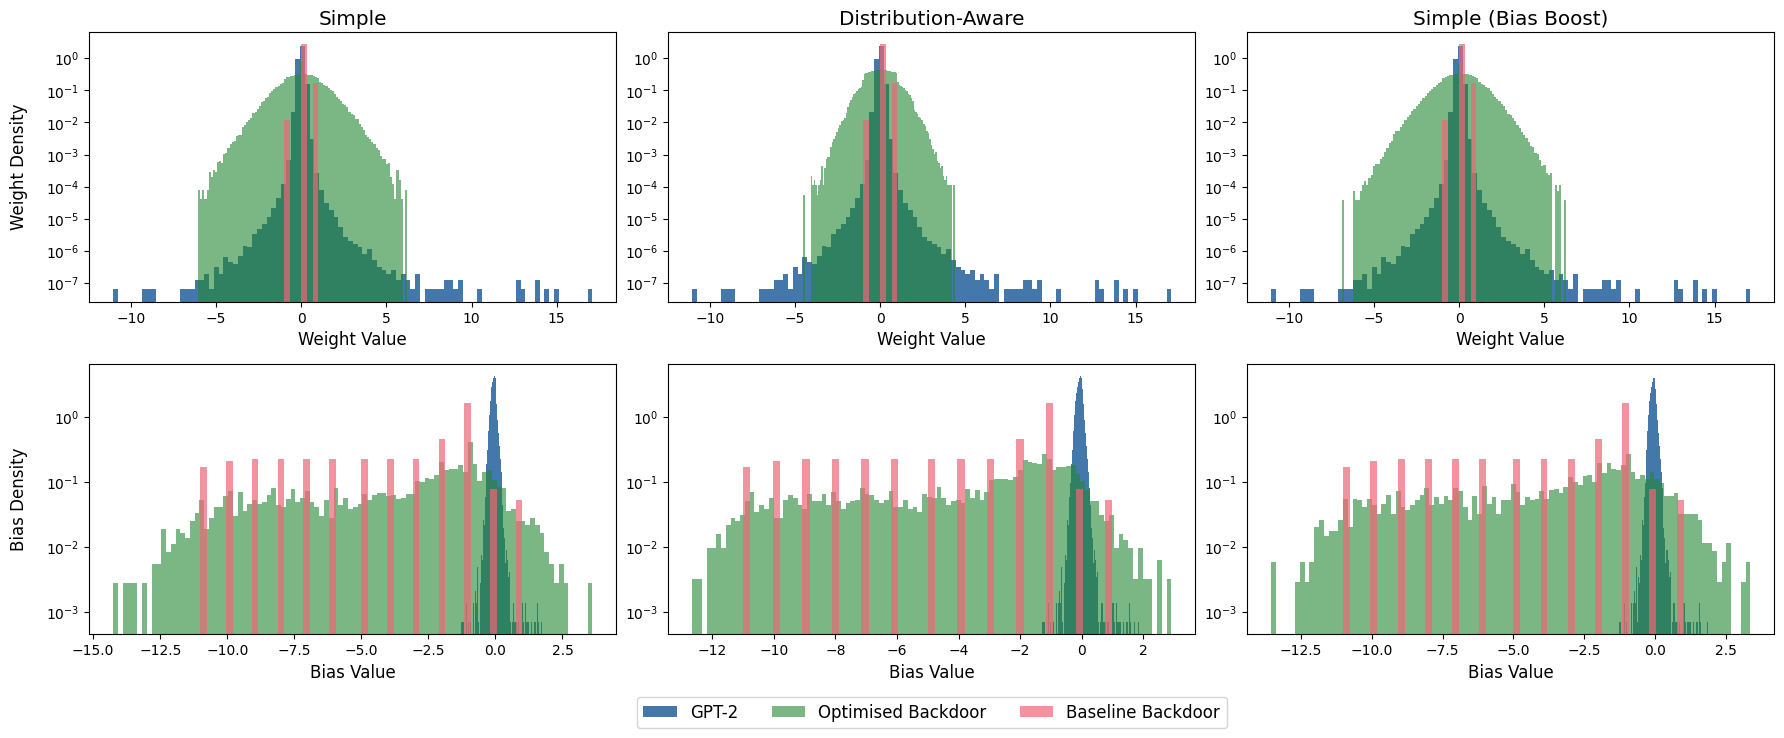

In [253]:
cols = ["Simple", "Distribution-Aware", "Simple (Bias Boost)"]
rows = ["Weight Density", "Bias Density"]
fig, axes = plt.subplots(2, 3, figsize=(20,7))

pad = 5

# Set column titles
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0,pad), xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')

# Set row titles
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation='vertical')
    
for col, (fitness_func, run_id) in enumerate(best_runs.items()):
    w,b = load_run_model_params(fitness_func, run_id)
    plot_distribution(w, target_weights, init_weights, w.mean(), w.std(), stats.kurtosis(w), target_weights_mean, init_w_mean, target_weights_std, target_weights_kurt, axes[0][col], param_type="Weight", n_baseline_bins=6)
    plot_distribution(b, target_bias, init_bias, b.mean(), b.std(), stats.kurtosis(b), target_bias_mean, init_b_mean, target_bias_std, target_bias_kurt, axes[1][col], param_type="Bias", n_baseline_bins=50)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

handles, labels = axes[0,0].get_legend_handles_labels()
axes[1,1].legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), fontsize="large")
fig.savefig("ga_distribution_comparison.pdf", bbox_inches="tight")

In [123]:
print(axes)

[[<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]]
